### 평가문항	상세기준
# 1. 인물모드 사진을 성공적으로 제작하였다.
#
# 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 
# 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
# 2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
#
# 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
# 3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
#
# 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

In [4]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
from matplotlib import pyplot as plt
import tensorflow as tf

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [5]:

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다.
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    # 모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 하고,
    # OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input

    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map


In [6]:
# model download
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
model_dir = os.getcwd()+'/model'
download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                               download_path)

MODEL = DeepLabModel(download_path)

In [7]:
# label에는 LABEL_NAMES 중에 하나가 들어간다.
def makePortraitImage(img_orig, label):
    img_resized, seg_map = MODEL.run(img_orig)
    print(img_orig.shape, img_resized.shape, seg_map.max())
    # img_orig 의 크기는 1280x720 이고 img_resized 의 크기는 513x288 이 출력됐습니다.
    # 입력 이미지 크기가 달라지면 resize 크기도 조금씩 달라지겠죠? (cv2는 채널을 HWC 순서로 표시한다는 점 잊지 마세요!)
    img_show = img_resized.copy()
    finding_index = LABEL_NAMES.index(label)
    seg_map = np.where(seg_map == finding_index, finding_index, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    # img_show = 0.6*img_show + 0.35*color_mask + 0.0 (bias텀인듯?)
    # img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
    img_bg_blur = cv2.blur(img_bg, (13,13))
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    return img_concat



(960, 720, 3) (513, 384, 3) 15


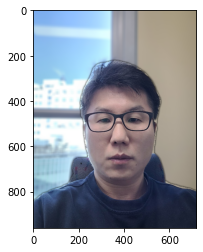

In [13]:
img_path = os.getcwd()+'/image/me.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_orig = cv2.imread(img_path)
img_concat = makePortraitImage(img_orig, 'person')
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

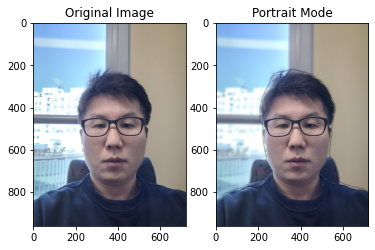

In [14]:

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Original Image')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Portrait Mode')

plt.show()

(1192, 2120, 3) (288, 513, 3) 15


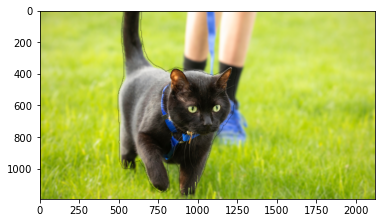

In [15]:
img_path = os.getcwd()+'/image/cat.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_orig = cv2.imread(img_path)
img_concat = makePortraitImage(img_orig, 'cat')
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

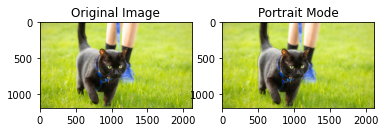

In [16]:

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Original Image')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Portrait Mode')

plt.show()

In [ ]:
# 배경전환 크로마키 사진
